In [2]:
import pandas as pd
from pathlib import Path

# Get the absolute path of the current script
ScriptPath = Path().absolute()
# Read the pickle file into a DataFrame
df=pd.read_pickle(ScriptPath.parent / 'data' / 'cus1.pkl')


In [77]:
# ============================================================ # 1. Imports # ================
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


# schöneres Plot-Design 
plt.style.use("seaborn-v0_8")
# ============================================================ # 2. Datenvorbereitung # ============================
df = df.sort_values('time_sec').reset_index(drop=True) 
df.head()



,time_sec,CUS1_PrecipitationIntensity,CUS1_AirTemperature,CUS1_RelativeHumidity,CUS1_AtmosphericPressure,CUS1_WindSpeed,CUS1_WindDirection,CUS1_SunAzimuth,CUS1_SunElevation
0,2024-06-06 07:13:35.694,0.0,14.4,70.8,1017.8,0.32,46.6,97.4,35.3
1,2024-06-06 07:13:38.705,0.0,14.4,71.0,1017.8,0.25,21.3,97.5,35.3
2,2024-06-06 07:13:41.704,0.0,14.4,71.2,1017.8,0.57,31.4,97.5,35.3
3,2024-06-06 07:13:44.718,0.0,14.4,71.3,1017.8,1.02,21.6,97.5,35.3
4,2024-06-06 07:13:47.725,0.0,14.4,71.4,1017.8,1.01,26.6,97.5,35.3


count                     16954957
mean     0 days 00:00:03.004807561
std      0 days 00:00:01.442791116
min                0 days 00:00:00
25%         0 days 00:00:02.999000
50%                0 days 00:00:03
75%         0 days 00:00:03.001000
max         0 days 00:57:29.946000
Name: delta_time, dtype: object
gaps length: 4983


c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


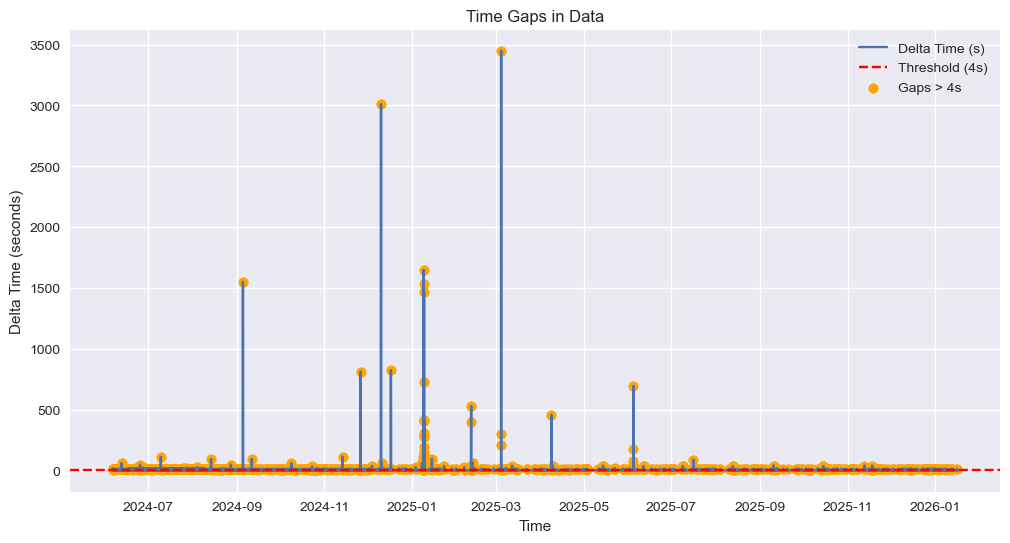

In [78]:
# ============================================================ # 3. Lückenanalyse # ============================
# Berechnung der Zeitdifferenzen
df_diff = df.copy()
df_diff['delta_time']=df['time_sec'].diff()
print(df_diff['delta_time'].describe())
# Identifikation der Lücken
gaps = df_diff[df_diff['delta_time'] > pd.Timedelta(seconds=4)] # Beispiel: Lücken größer als 4 Sekunde
print(f"gaps length: {len(gaps)}")

 
import matplotlib.pyplot as plt  
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(df_diff['time_sec'], df_diff['delta_time'].dt.total_seconds(), label='Delta Time (s)')
plt.axhline(y=4, color='r', linestyle='--', label='Threshold (4s)')
plt.scatter(gaps['time_sec'], gaps['delta_time'].dt.total_seconds(), color='orange', label='Gaps > 4s')
plt.xlabel('Time')  
plt.ylabel('Delta Time (seconds)')
plt.title('Time Gaps in Data')
plt.legend()
plt.show()  


In [79]:
print(df.columns)

Index(['time_sec', 'CUS1_PrecipitationIntensity', 'CUS1_AirTemperature',
       'CUS1_RelativeHumidity', 'CUS1_AtmosphericPressure', 'CUS1_WindSpeed',
       'CUS1_WindDirection', 'CUS1_SunAzimuth', 'CUS1_SunElevation'],
      dtype='object')


In [80]:
#  ============================================================ # STARTE NAN-ANALYSE FÜR PHYSIKALISCHE GRÖSSEN # ============================
def nan_summary(df):
    '''
    Erstellt eine Zusammenfassung der NaN-Werte für physikalische Messgrößen im DataFrame.

    '''
# Definiere die physikalischen Spalten
    phys_cols = ['time_sec', 'CUS1_PrecipitationIntensity','CUS1_AirTemperature', 'CUS1_RelativeHumidity','CUS1_AtmosphericPressure', 'CUS1_WindSpeed', 'CUS1_WindDirection',
       'CUS1_SunAzimuth', 'CUS1_SunElevation']
    phys_cols=[col for col in phys_cols if col in df.columns]
    df_copy = df.copy()
    for col in phys_cols:
        df_copy[col + '_is_nan'] = df_copy[col].isna().astype(int)
    summary = df_copy[[col + '_is_nan' for col in phys_cols]].sum()
    return summary
#
print(nan_summary(df))


time_sec_is_nan                         0
CUS1_PrecipitationIntensity_is_nan      0
CUS1_AirTemperature_is_nan              0
CUS1_RelativeHumidity_is_nan            0
CUS1_AtmosphericPressure_is_nan         0
CUS1_WindSpeed_is_nan                 114
CUS1_WindDirection_is_nan             114
CUS1_SunAzimuth_is_nan                  0
CUS1_SunElevation_is_nan                0
dtype: int64


In [81]:
#---------------------------------------------- Dart Cleaning for just temperature--------------------------------------------------------
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller


print("Cleaning data without full copy...")

# 1) Nur benötigte Spalten
df_clean = df.copy()



print(f"Original rows: {len(df)}")
print(f"After removing duplicates: {len(df_clean)}")


Cleaning data without full copy...
Original rows: 16954958
After removing duplicates: 16954958


In [82]:

# 3) time_sec in echten DatetimeIndex umwandeln
df_clean['time_sec'] = pd.to_datetime(df_clean['time_sec'])

# 4) Zeit als Index setzen
#df_clean = df_clean.set_index('time_sec')

# 5) Auf 3 Sekunden resamplen → erzeugt lückenlosen Zeitindex
#df_clean = df_clean.resample('3s').mean()


df_clean['time_sec'] = df_clean['time_sec'].dt.floor('3s')
df_clean = df_clean.drop_duplicates(subset=['time_sec'], keep='first')

df_clean = df_clean.set_index('time_sec')
# 2) Doppelte Zeitstempel entfernen

# 6) Fehlende Werte füllen
#df_clean = df_clean.ffill().bfill()



In [83]:
phys_col= df_clean.columns.tolist()
print(f"Physikalische Spalten: {phys_col}")

Physikalische Spalten: ['CUS1_PrecipitationIntensity', 'CUS1_AirTemperature', 'CUS1_RelativeHumidity', 'CUS1_AtmosphericPressure', 'CUS1_WindSpeed', 'CUS1_WindDirection', 'CUS1_SunAzimuth', 'CUS1_SunElevation']


In [ ]:
from darts import concatenate
phys_col= df_clean.columns.tolist()
print(f"Physikalische Spalten: {phys_col}")
ts_all= None
for col in phys_col:
# 7) Direkt in Darts TimeSeries umwandeln (ohne reset_index!)
    ts = TimeSeries.from_dataframe(
    df_clean,
    value_cols=[col],
    fill_missing_dates=True ,  # wichtig!
    freq='3s'               # wichtig!
    )

    filler= MissingValuesFiller()
    ts_filled = filler.transform(ts, method="linear")

    print(f"✅ Funktioniert! {len(ts)} regelmäßige Punkte")
    print(f"Frequenz erkannt: {ts.freq}")
    if ts_all is None: ts_all = ts_filled 
    else: ts_all = concatenate([ts_all, ts_filled], axis=1)

Physikalische Spalten: ['CUS1_PrecipitationIntensity', 'CUS1_AirTemperature', 'CUS1_RelativeHumidity', 'CUS1_AtmosphericPressure', 'CUS1_WindSpeed', 'CUS1_WindDirection', 'CUS1_SunAzimuth', 'CUS1_SunElevation']
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>


<Axes: xlabel='time_sec'>

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


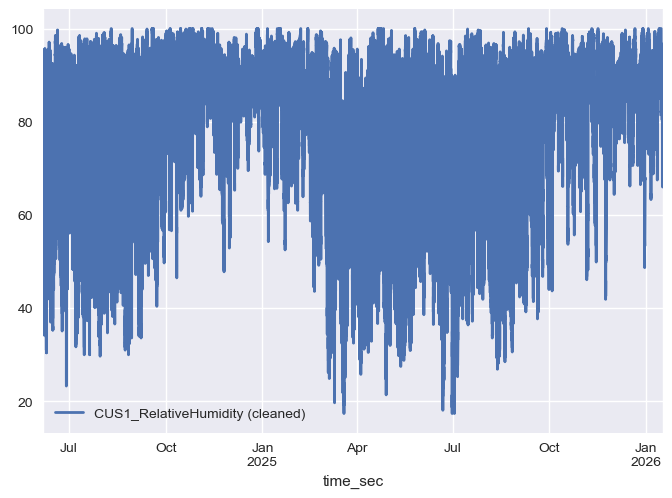

In [ ]:
ts_all['CUS1_RelativeHumidity'].plot(label='CUS1_RelativeHumidity (cleaned)')

In [ ]:
# Lückenanalyse nach Dart Cleaning
gapses=ts_all.gaps(mode='all')
print(gapses)

Empty DataFrame
Columns: [gap_start, gap_end]
Index: []


In [ ]:
# Testen ob keine Lücke in unserem Databases steht 

time_index = ts_all.time_index  # pandas DatetimeIndex
delta_from_index = pd.Series(time_index).diff()
gapses = delta_from_index > pd.Timedelta(seconds=4) # Beispiel: Lücken größer als 4 Sekunde
gapses.describe()

count     16982129
unique           1
top          False
freq      16982129
Name: time_sec, dtype: object

In [ ]:
# ================= reset index and nan summary
df_from_ts_all = ts_all.to_dataframe(copy=True).reset_index()
df_from_ts_all.head()
print(nan_summary(df_from_ts_all)) # NAN summary

time_sec_is_nan                       0
CUS1_PrecipitationIntensity_is_nan    0
CUS1_AirTemperature_is_nan            0
CUS1_RelativeHumidity_is_nan          0
CUS1_AtmosphericPressure_is_nan       0
CUS1_WindSpeed_is_nan                 0
CUS1_WindDirection_is_nan             0
CUS1_SunAzimuth_is_nan                0
CUS1_SunElevation_is_nan              0
dtype: int64


In [ ]:
df_from_ts_all.head()


,time_sec,CUS1_PrecipitationIntensity,CUS1_AirTemperature,CUS1_RelativeHumidity,CUS1_AtmosphericPressure,CUS1_WindSpeed,CUS1_WindDirection,CUS1_SunAzimuth,CUS1_SunElevation
0,2024-06-06 07:13:33,0.0,14.4,70.8,1017.8,0.32,46.6,97.4,35.3
1,2024-06-06 07:13:36,0.0,14.4,71.0,1017.8,0.25,21.3,97.5,35.3
2,2024-06-06 07:13:39,0.0,14.4,71.2,1017.8,0.57,31.4,97.5,35.3
3,2024-06-06 07:13:42,0.0,14.4,71.3,1017.8,1.02,21.6,97.5,35.3
4,2024-06-06 07:13:45,0.0,14.4,71.4,1017.8,1.01,26.6,97.5,35.3


In [ ]:
df_clean.head()

,CUS1_PrecipitationIntensity,CUS1_AirTemperature,CUS1_RelativeHumidity,CUS1_AtmosphericPressure,CUS1_WindSpeed,CUS1_WindDirection,CUS1_SunAzimuth,CUS1_SunElevation
time_sec,,,,,,,,
2024-06-06 07:13:33,0.0,14.4,70.8,1017.8,0.32,46.6,97.4,35.3
2024-06-06 07:13:36,0.0,14.4,71.0,1017.8,0.25,21.3,97.5,35.3
2024-06-06 07:13:39,0.0,14.4,71.2,1017.8,0.57,31.4,97.5,35.3
2024-06-06 07:13:42,0.0,14.4,71.3,1017.8,1.02,21.6,97.5,35.3
2024-06-06 07:13:45,0.0,14.4,71.4,1017.8,1.01,26.6,97.5,35.3


C:\Users\syassinho\AppData\Local\Temp\ipykernel_4252\2199397484.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


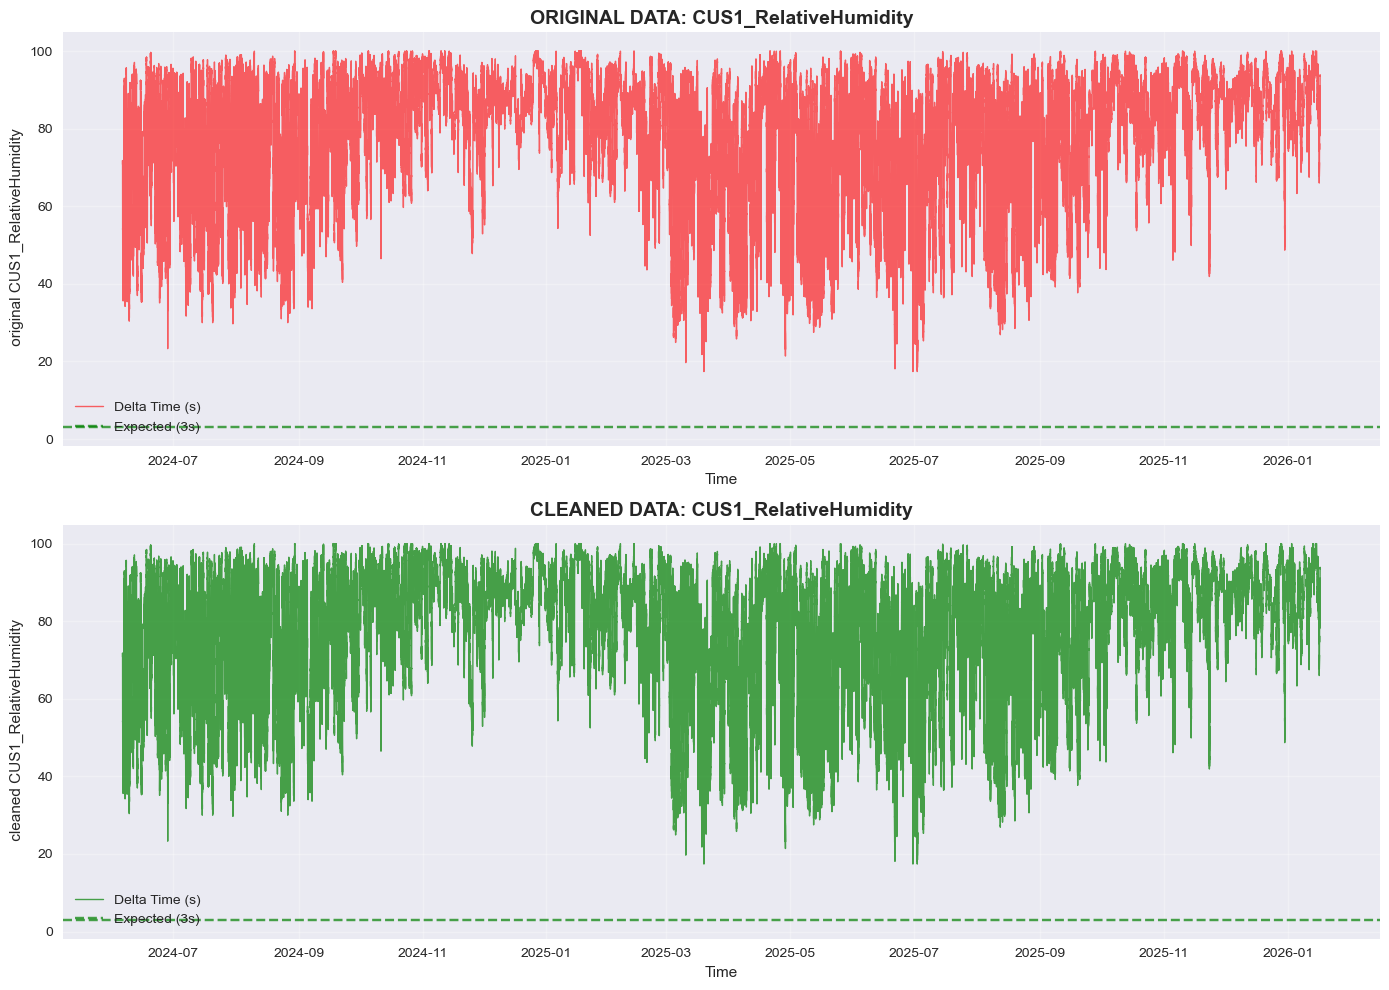

In [ ]:
def vergleiche_dataframes(Phys_col):
    """
    Vergleicht zwei DataFrames und gibt die Anzahl der Zeilen und Spalten zurück.
   """
    df_clean.reset_index(inplace=True)

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: ORIGINAL DATA - Delta Time
    axes[0].set_title(f'ORIGINAL DATA: {Phys_col}', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].plot(df_clean['time_sec'], df_clean[Phys_col], label='Delta Time (s)', color='red', alpha=0.6, linewidth=1)
    axes[0].axhline(y=3, color='g', linestyle='--', label='Expected (3s)', alpha=0.7)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel(f' original {Phys_col}')
    axes[0].legend()

    # Plot 2: CLEANED DATA - Delta Time
    axes[1].set_title(f'CLEANED DATA: {Phys_col}', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].plot(df_from_ts_all['time_sec'], df_from_ts_all[Phys_col], label='Delta Time (s)', color='green', alpha=0.7, linewidth=1)
    axes[1].axhline(y=3, color='g', linestyle='--', label='Expected (3s)', alpha=0.7)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel(f' cleaned {Phys_col}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
vergleiche_dataframes('CUS1_RelativeHumidity')

In [ ]:
import pickle
with open(ScriptPath.parent / 'data' / 'ts_all_cus1.pkl', 'wb') as f:
    pickle.dump(ts_all, f)

In [5]:
from pathlib import Path
ScriptPath = Path().absolute()
# Read the pickle file into a time series

import pickle
with open(ScriptPath.parent / 'data' / 'ts_all_cus1.pkl', 'rb') as f:

    ts_all = pickle.load(f)

In [6]:
# ============================================================ # 3s data are to much for training # ============================
from darts.utils.missing_values import fill_missing_values
from darts.utils.statistics import check_seasonality
print("Saisonalität prüfen für CUS1_RelativeHumidity:")
# 
ts_all_hourly = ts_all.resample('1h') # from 3Sly to hourly timestemp
ts_all_hourly= fill_missing_values(ts_all_hourly, fill='auto') # remove NAN values 
ts_all_hourly


Saisonalität prüfen für CUS1_RelativeHumidity:


component,CUS1_PrecipitationIntensity,CUS1_AirTemperature,CUS1_RelativeHumidity,CUS1_AtmosphericPressure,CUS1_WindSpeed,CUS1_WindDirection,CUS1_SunAzimuth,CUS1_SunElevation
time_sec,,,,,,,,
2024-06-06 07:00:00,0.0,16.0,66.2,1017.6,0.38,317.9,107.8,42.4
2024-06-06 08:00:00,0.0,16.0,66.2,1017.6,0.38,317.9,107.8,42.4
2024-06-06 09:00:00,0.0,17.1,49.7,1017.2,1.97,133.4,123.9,51.0
2024-06-06 10:00:00,0.0,18.7,47.8,1016.6,1.25,243.0,144.7,57.8
2024-06-06 11:00:00,0.0,19.3,50.1,1016.3,0.98,240.8,171.0,61.4
...,...,...,...,...,...,...,...,...
2026-01-16 18:00:00,0.0,6.6,80.5,1017.6,1.99,32.4,262.3,-20.7
2026-01-16 19:00:00,0.0,6.0,81.8,1017.8,1.82,43.5,273.9,-30.1
2026-01-16 20:00:00,0.0,5.4,83.5,1018.2,2.13,14.3,286.8,-39.3


In [19]:



# ============================================================ # 4. Plotten der bereinigten Daten # ============================

from darts.utils.statistics import granger_causality_tests


def causality_of_Measurement(cause,max_lag):
    '''
          the causality between the effect (Precipitation) and the cause (other measurement)
    '''
    global Max_lag
    Max_lag = max_lag
    
    ts_cause = ts_all_hourly[cause]
    Precipitatiom = ts_all_hourly['CUS1_PrecipitationIntensity'] # Precipitation
   
    result = granger_causality_tests(ts_cause,Precipitatiom,maxlag=Max_lag,addconst=True)
    for lag in range(1,Max_lag-1):
        Needed_f_p[lag]= [result[lag][0]['ssr_ftest'][0],result[lag][0]['ssr_ftest'][1]]
        
        print(f"result {Needed_result}")

    return Needed_result




Phys_com = ts_all_hourly.components #the whole components
Phys_com=[com for com in Phys_com if com != 'CUS1_PrecipitationIntensity']

Needed_result={}
for com in Phys_com:
    Needed_f_p={}
    causality_of_Measurement(com,7)
    Needed_result[com]= Needed_f_p


    

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\darts\utils\statistics.py:484: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4482 , p=0.0012  , df_denom=14148, df_num=1
ssr based chi2 test:   chi2=10.4504 , p=0.0012  , df=1
likelihood ratio test: chi2=10.4465 , p=0.0012  , df=1
parameter F test:         F=10.4482 , p=0.0012  , df_denom=14148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.9359  , p=0.0000  , df_denom=14145, df_num=2
ssr based chi2 test:   chi2=19.8788 , p=0.0000  , df=2
likelihood ratio test: chi2=19.8648 , p=0.0000  , df=2
parameter F test:         F=9.9359  , p=0.0000  , df_denom=14145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6562  , p=0.0002  , df_denom=14142, df_num=3
ssr based chi2 test:   chi2=19.9784 , p=0.0002  , df=3
likelihood ratio test: chi2=19.9643 , p=0.0002  , df=3
parameter F test:         F=6.6562  , p=0.0002  , df_denom=14142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9809  

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\darts\utils\statistics.py:484: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3949  , p=0.0361  , df_denom=14148, df_num=1
ssr based chi2 test:   chi2=4.3958  , p=0.0360  , df=1
likelihood ratio test: chi2=4.3951  , p=0.0360  , df=1
parameter F test:         F=4.3949  , p=0.0361  , df_denom=14148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.8140 , p=0.0000  , df_denom=14145, df_num=2
ssr based chi2 test:   chi2=21.6356 , p=0.0000  , df=2
likelihood ratio test: chi2=21.6191 , p=0.0000  , df=2
parameter F test:         F=10.8140 , p=0.0000  , df_denom=14145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2101  , p=0.0001  , df_denom=14142, df_num=3
ssr based chi2 test:   chi2=21.6411 , p=0.0001  , df=3
likelihood ratio test: chi2=21.6245 , p=0.0001  , df=3
parameter F test:         F=7.2101  , p=0.0001  , df_denom=14142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.7131  

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\darts\utils\statistics.py:484: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=60.2531 , p=0.0000  , df_denom=14148, df_num=1
ssr based chi2 test:   chi2=60.2659 , p=0.0000  , df=1
likelihood ratio test: chi2=60.1379 , p=0.0000  , df=1
parameter F test:         F=60.2531 , p=0.0000  , df_denom=14148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=30.7541 , p=0.0000  , df_denom=14145, df_num=2
ssr based chi2 test:   chi2=61.5300 , p=0.0000  , df=2
likelihood ratio test: chi2=61.3966 , p=0.0000  , df=2
parameter F test:         F=30.7541 , p=0.0000  , df_denom=14145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=20.3454 , p=0.0000  , df_denom=14142, df_num=3
ssr based chi2 test:   chi2=61.0664 , p=0.0000  , df=3
likelihood ratio test: chi2=60.9350 , p=0.0000  , df=3
parameter F test:         F=20.3454 , p=0.0000  , df_denom=14142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.6933 

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\darts\utils\statistics.py:484: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4045  , p=0.0037  , df_denom=14148, df_num=1
ssr based chi2 test:   chi2=8.4063  , p=0.0037  , df=1
likelihood ratio test: chi2=8.4038  , p=0.0037  , df=1
parameter F test:         F=8.4045  , p=0.0037  , df_denom=14148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3982  , p=0.0045  , df_denom=14145, df_num=2
ssr based chi2 test:   chi2=10.8002 , p=0.0045  , df=2
likelihood ratio test: chi2=10.7961 , p=0.0045  , df=2
parameter F test:         F=5.3982  , p=0.0045  , df_denom=14145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0864  , p=0.0066  , df_denom=14142, df_num=3
ssr based chi2 test:   chi2=12.2654 , p=0.0065  , df=3
likelihood ratio test: chi2=12.2600 , p=0.0065  , df=3
parameter F test:         F=4.0864  , p=0.0066  , df_denom=14142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9963  

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\darts\utils\statistics.py:484: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1247  , p=0.2889  , df_denom=14148, df_num=1
ssr based chi2 test:   chi2=1.1249  , p=0.2889  , df=1
likelihood ratio test: chi2=1.1249  , p=0.2889  , df=1
parameter F test:         F=1.1247  , p=0.2889  , df_denom=14148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1060  , p=0.3309  , df_denom=14145, df_num=2
ssr based chi2 test:   chi2=2.2127  , p=0.3308  , df=2
likelihood ratio test: chi2=2.2126  , p=0.3308  , df=2
parameter F test:         F=1.1060  , p=0.3309  , df_denom=14145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7750  , p=0.5078  , df_denom=14142, df_num=3
ssr based chi2 test:   chi2=2.3262  , p=0.5075  , df=3
likelihood ratio test: chi2=2.3260  , p=0.5076  , df=3
parameter F test:         F=0.7750  , p=0.5078  , df_denom=14142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6161  

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\darts\utils\statistics.py:484: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4357  , p=0.0112  , df_denom=14148, df_num=1
ssr based chi2 test:   chi2=6.4370  , p=0.0112  , df=1
likelihood ratio test: chi2=6.4356  , p=0.0112  , df=1
parameter F test:         F=6.4357  , p=0.0112  , df_denom=14148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0817  , p=0.0459  , df_denom=14145, df_num=2
ssr based chi2 test:   chi2=6.1657  , p=0.0458  , df=2
likelihood ratio test: chi2=6.1643  , p=0.0459  , df=2
parameter F test:         F=3.0817  , p=0.0459  , df_denom=14145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3587  , p=0.0696  , df_denom=14142, df_num=3
ssr based chi2 test:   chi2=7.0796  , p=0.0694  , df=3
likelihood ratio test: chi2=7.0778  , p=0.0695  , df=3
parameter F test:         F=2.3587  , p=0.0696  , df_denom=14142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7522  

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\darts\utils\statistics.py:484: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)
ts_cause doesn't seem to be stationary. Please review granger causality validity in your problem context.



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8420  , p=0.3588  , df_denom=14148, df_num=1
ssr based chi2 test:   chi2=0.8421  , p=0.3588  , df=1
likelihood ratio test: chi2=0.8421  , p=0.3588  , df=1
parameter F test:         F=0.8420  , p=0.3588  , df_denom=14148, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4569  , p=0.0116  , df_denom=14145, df_num=2
ssr based chi2 test:   chi2=8.9169  , p=0.0116  , df=2
likelihood ratio test: chi2=8.9141  , p=0.0116  , df=2
parameter F test:         F=4.4569  , p=0.0116  , df_denom=14145, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8961  , p=0.0085  , df_denom=14142, df_num=3
ssr based chi2 test:   chi2=11.6941 , p=0.0085  , df=3
likelihood ratio test: chi2=11.6892 , p=0.0085  , df=3
parameter F test:         F=3.8961  , p=0.0085  , df_denom=14142, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6946  

In [20]:
Needed_result

{'CUS1_AirTemperature': {1: [10.44818006683021, 0.0012305150841024845],
  2: [9.935873029206801, 4.8745371767035324e-05],
  3: [6.656176931226086, 0.00017341408021000207],
  4: [4.980860818997106, 0.0005200529845948023],
  5: [3.9724533278004777, 0.0013331177957908364]},
 'CUS1_RelativeHumidity': {1: [4.3948552810191375, 0.03606523343309994],
  2: [10.813976850221424, 2.0283194183839803e-05],
  3: [7.210117717524724, 7.845461410790905e-05],
  4: [5.71306585549524, 0.00013658121971236962],
  5: [4.63509249886543, 0.0003147464147348058]},
 'CUS1_AtmosphericPressure': {1: [60.25312126326339, 8.910830487660968e-15],
  2: [30.75410696091717, 4.7056165935481004e-14],
  3: [20.345387852002855, 3.7623023625090546e-13],
  4: [15.693338808919146, 8.083715277464187e-13],
  5: [12.463952872836188, 4.2846509341333495e-12]},
 'CUS1_WindSpeed': {1: [8.40448643094327, 0.0037487147286295493],
  2: [5.3981794997411665, 0.004534137362167673],
  3: [4.086428380695954, 0.006560587479841651],
  4: [4.996285

In [100]:

import pandas as pd
df_fpWerte=pd.DataFrame(columns=['Sensor', 'lag' , 'f_wert','p_wert'])

i=0
for pys , value in Needed_result.items() :
   for lag ,f_p in value.items():
      df_fpWerte.loc[i] = [pys , lag ,f_p[0] , f_p[1]] 
      i=i+1
      print(f'  pys werte {pys}  fp werte {f_p}  und lag werte {lag}')
      #f.append(Needed_result[pys][lag][0])
   



  pys werte CUS1_AirTemperature  fp werte [10.44818006683021, 0.0012305150841024845]  und lag werte 1
  pys werte CUS1_AirTemperature  fp werte [9.935873029206801, 4.8745371767035324e-05]  und lag werte 2
  pys werte CUS1_AirTemperature  fp werte [6.656176931226086, 0.00017341408021000207]  und lag werte 3
  pys werte CUS1_AirTemperature  fp werte [4.980860818997106, 0.0005200529845948023]  und lag werte 4
  pys werte CUS1_AirTemperature  fp werte [3.9724533278004777, 0.0013331177957908364]  und lag werte 5
  pys werte CUS1_RelativeHumidity  fp werte [4.3948552810191375, 0.03606523343309994]  und lag werte 1
  pys werte CUS1_RelativeHumidity  fp werte [10.813976850221424, 2.0283194183839803e-05]  und lag werte 2
  pys werte CUS1_RelativeHumidity  fp werte [7.210117717524724, 7.845461410790905e-05]  und lag werte 3
  pys werte CUS1_RelativeHumidity  fp werte [5.71306585549524, 0.00013658121971236962]  und lag werte 4
  pys werte CUS1_RelativeHumidity  fp werte [4.63509249886543, 0.00031

In [105]:
df_f_pivot=pd.pivot(df_fpWerte ,index= 'Sensor',columns='lag', values='f_wert')
df_p_pivot=pd.pivot(df_fpWerte ,index= 'Sensor',columns='lag', values='p_wert')

df_p_pivot

lag,1,2,3,4,5
Sensor,,,,,
CUS1_AirTemperature,1.230515e-03,4.874537e-05,1.734141e-04,5.200530e-04,1.333118e-03
CUS1_AtmosphericPressure,8.910830e-15,4.705617e-14,3.762302e-13,8.083715e-13,4.284651e-12
CUS1_RelativeHumidity,3.606523e-02,2.028319e-05,7.845461e-05,1.365812e-04,3.147464e-04
CUS1_SunAzimuth,1.119585e-02,4.590997e-02,6.955905e-02,1.354969e-01,2.188552e-01
CUS1_SunElevation,3.588495e-01,1.161461e-02,8.548456e-03,5.198989e-03,8.427134e-03
CUS1_WindDirection,2.889362e-01,3.309167e-01,5.077653e-01,6.509939e-01,7.857528e-01
CUS1_WindSpeed,3.748715e-03,4.534137e-03,6.560587e-03,5.056934e-04,1.040993e-03


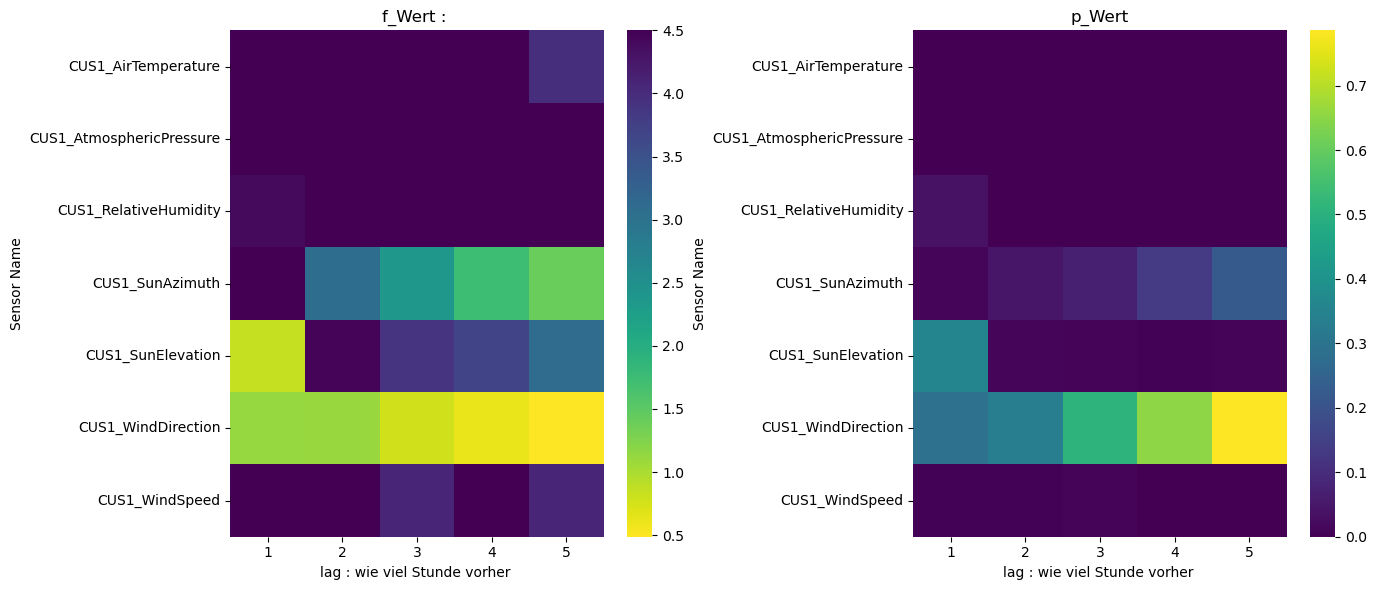

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2,figsize=(14, 6))
sns.heatmap(df_f_pivot,cmap='viridis_r',vmax=4.5,ax=axes[0])
axes[0].set_title('f_Wert : ')
axes[0].set_xlabel('lag : wie viel Stunde vorher ')
axes[0].set_ylabel('Sensor Name')

sns.heatmap(df_p_pivot,cmap='viridis',ax=axes[1])
axes[1].set_title('p_Wert')
axes[1].set_xlabel('lag : wie viel Stunde vorher ')
axes[1].set_ylabel('Sensor Name')
plt.tight_layout()
plt.show()





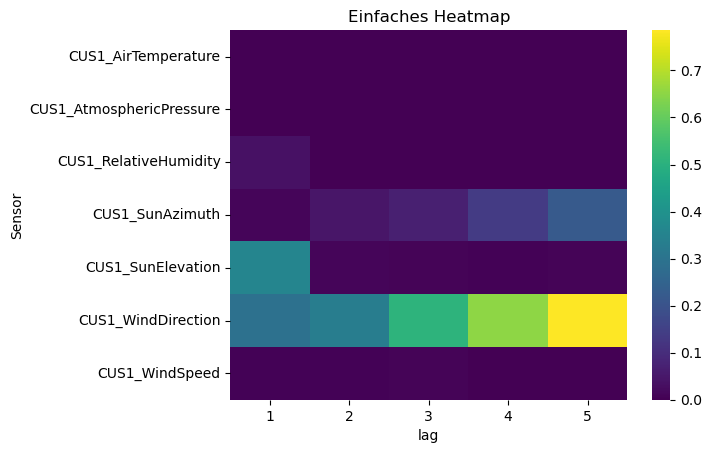

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_p_pivot,cmap='viridis')




plt.title("Einfaches Heatmap")
plt.show()